# Reading the MUR SST Icechunk Virtual Store with xarray and zarr-python

This notebook demonstrates how to open, subset, and plot the MUR SST virtual dataset using either xarray or zarr-python. Documentation for this dataset can be found [in this design doc](https://github.com/earth-mover/icechunk-nasa/blob/main/design-docs/mursst-virtual-icechunk-store.md).

It also includes a demonstration of visualizing the data with hvplot.

## Step 0. Ensure required version libraries are installed including icechunk > 1.0

In [3]:
%%capture
!pip install icechunk==1.1.5 xarray==2025.9.0 zarr==3.0.8 earthaccess==0.14.0 kerchunk==0.2.8 virtualizarr==1.3.2 fsspec==2025.9.0

In [4]:
pip list | grep -E "zarr|^xarray|virtualizarr|icechunk|kerchunk|boto3|fsspec|boto3|earthaccess"

boto3                         1.40.18
earthaccess                   0.14.0
fsspec                        2025.9.0
icechunk                      1.1.5
kerchunk                      0.2.8
virtualizarr                  1.3.2
xarray                        2025.9.0
zarr                          3.0.8
Note: you may need to restart the kernel to use updated packages.


In [1]:
import boto3
from datetime import datetime, timedelta
import earthaccess
import fsspec
import hvplot.xarray
import holoviews as hv
from holoviews import opts
import matplotlib.pyplot as plt
import numpy as np
import panel as pn

import xarray as xr
import zarr
import icechunk
from icechunk.credentials import s3_credentials

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from typing import Optional

## Step 1. Set zarr runtime configuration

Async and threading operations can be set via zarr.config. Please also see [zarr-python runtime configuration documentation](https://zarr.readthedocs.io/en/stable/user-guide/config.html).

* `async.concurrency` controls how many chunks can be fetched asynchronously at once.
* `threading.max_workers` determines how many threads handle the decompression or processing of those fetched chunks.

The default setting for `threading.max_workers` is `None` so presumably this uses all threads available.

In [2]:
# concurrency=300 seems to be a sweeet spot for smaller EC2s. Fast open time of a few secconds for MUR.
zarr.config.set({
    'async': {'concurrency': 300, 'timeout': None},
    'threading': {'max_workers': 4}
})

## Step 2. Set other variables

In [3]:
bucket_name = 'nasa-eodc-public'
store_name = "MUR-JPL-L4-GLOB-v4.1-virtual-v1"

# Gulf of Tehuantepec, MX
lat_min = 14.
lat_max = 15.
lon_min = -96.
lon_max = -95.

lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

start_date = '2003-01-01'
end_date = '2008-12-31'
time_range =(start_date, end_date)

lat_min = -90
lon_min = -180
resolution = 0.01
ea_creds = None


## Step 3. Fetch earthaccess credentials

Note: You can skip this step if you have direct bucket access to `s3://podaac-ops-cumulus-protected/`.

In [4]:
s3 = boto3.client("s3")

earthaccess.login()
ea_creds = earthaccess.get_s3_credentials(daac='PODAAC')

storage_path = "s3://" + bucket_name + "/" + store_name +"/"
print(storage_path)


s3://nasa-eodc-public/MUR-JPL-L4-GLOB-v4.1-virtual-v1/


## Step 4. Initialize the repo

In [5]:
# get_repo subroutine 

def get_repo(bucket_name: str, store_name: str, ea_creds: Optional[dict] = None):
    storage = icechunk.s3_storage(
        bucket=bucket_name,
        prefix=f"icechunk/{store_name}",
        anonymous=True
    )

    config = icechunk.RepositoryConfig.default()
    #config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3", "s3://", icechunk.s3_store(region="us-west-2")))
    config.set_virtual_chunk_container(icechunk.VirtualChunkContainer("s3://nasa-eodc-public/", icechunk.s3_store(region="us-west-2")))

    repo_config = dict(
        storage=storage,
        config=config,
    )
    if ea_creds:
        earthdata_credentials = icechunk.containers_credentials(
            {"s3://nasa-eodc-public/": icechunk.s3_credentials(
                access_key_id=ea_creds['accessKeyId'],
                secret_access_key=ea_creds['secretAccessKey'],
                session_token=ea_creds['sessionToken'] )
            }
        )
        repo_config['authorize_virtual_chunk_access'] = earthdata_credentials
        #repo_config['virtual_chunk_credentials'] = earthdata_credentials

    return icechunk.Repository.open(**repo_config)

In [6]:
repo = get_repo(bucket_name=bucket_name, store_name=store_name, ea_creds=ea_creds)
session = repo.readonly_session(branch="main")

  2025-09-23T19:32:21.489065Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-09-23T19:32:21.489095Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-09-23T19:32:21.489098Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-09-23T19:32:21.489101Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: relative URL without a base
    at icechunk/src/virtual_chunks.rs:272

  2025-09-23T19:32:21.489105Z  WARN icechunk::virtual_chunks: Invalid virtual chunk container, ignoring it: Url prefix for s3:// containers must include a host
    at icechunk/src/virtual_chunks.rs:272



## Step 5 Option 1: Read and plot with `xarray`

In [7]:
%%time
mur_ds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

CPU times: user 403 ms, sys: 28.2 ms, total: 431 ms
Wall time: 517 ms


IcechunkError: Failed to decode variable 'time':   x no virtual chunk container can handle the chunk location (s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc), edit the
  | repository configuration adding a virtual chunk container for the chunk references, see https://icechunk.io/en/stable/virtual/
  | 
  | context:
  |    0: icechunk::store::get
  |            with key="time/c/0" byte_range=From(0)
  |              at icechunk/src/store.rs:198
  | 
  `-> no virtual chunk container can handle the chunk location (s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020601090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc), edit the
      repository configuration adding a virtual chunk container for the chunk references, see https://icechunk.io/en/stable/virtual/


In [ ]:
print(mur_ds)
mur_ds

In [ ]:
%%time
#mur_subset = mur_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(["lat", "lon"]).rolling(time=7, center=True).mean().load()
mur_subset = mur_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(["lat", "lon"]).resample(time="W").mean().load()

In [ ]:
fig = plt.figure(figsize=(16, 6)) 
ax = fig.add_subplot() 
mur_subset.plot()
plt.show()

## Open the PO.DAAC OSTIA VDS created with virtualizarr

In [8]:
fs = earthaccess.get_s3_filesystem(daac="PODAAC")

In [9]:
%%time
vds_link = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-public/virtual_collections/OSTIA-UKMO-L4-GLOB-REP-v2.0/OSTIA-UKMO-L4-GLOB-REP-v2.0_virtual_s3.json"
ostia_ds = xr.open_dataset(
    vds_link,
    engine="kerchunk",
    chunks={},
    backend_kwargs={
        "storage_options": {
            "remote_protocol": "s3",
            "remote_options": fs.storage_options
        }
    }
)

CPU times: user 3.69 s, sys: 599 ms, total: 4.29 s
Wall time: 8.09 s


In [20]:
print(ostia_ds)

<xarray.Dataset> Size: 11TB
Dimensions:           (time: 15340, lat: 3600, lon: 7200)
Coordinates:
  * time              (time) datetime64[ns] 123kB 1982-01-01T12:00:00 ... 202...
  * lat               (lat) float32 14kB -89.97 -89.93 -89.88 ... 89.93 89.97
  * lon               (lon) float32 29kB -180.0 -179.9 -179.9 ... 179.9 180.0
Data variables:
    analysed_sst      (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1200, 2400), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float64 3TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
    mask              (time, lat, lon) float32 2TB dask.array<chunksize=(1, 1800, 3600), meta=np.ndarray>
Attributes: (12/39)
    Conventions:                CF-1.4, ACDD-1.3
    title:                      Global SST & Sea Ice Analysis, L4 OSTIA, 0.05...
    summary:                    A merged, multi-sensor L4 Foundation SST p

In [10]:
%%time
ostia_subset = ostia_ds.analysed_sst.sel(lat=slice(*lat_range), lon=slice(*lon_range), time=slice(*time_range)).mean(["lat", "lon"]).resample(time="W").mean().load()

CPU times: user 3min 53s, sys: 4.89 s, total: 3min 58s
Wall time: 3min 18s


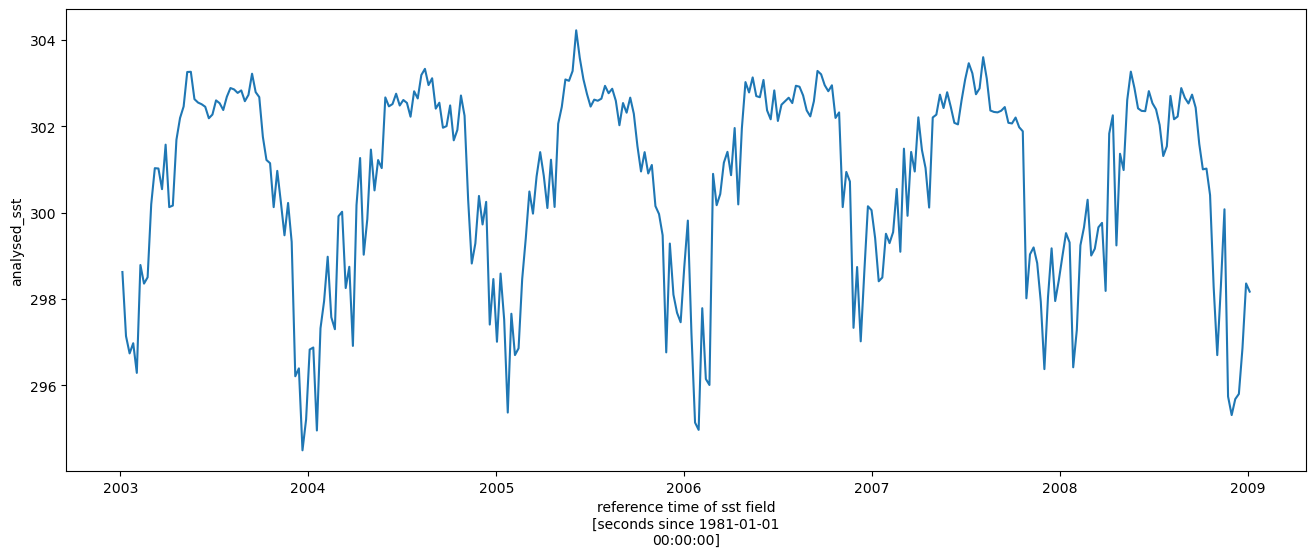

In [11]:
fig = plt.figure(figsize=(16, 6)) 
ax = fig.add_subplot() 
ostia_subset.plot()
plt.show()

## Perform overlploting of MUR vs OSTIA SST

In [ ]:
fig = plt.figure(figsize=(16,6), layout="tight")
ax = plt.axes()
plt.plot(ostia_subset["time"].values, ostia_subset, color='blue', label='OSTIA (Virtualizarr)')
plt.plot(mur_subset["time"].values, mur_subset, color='red',label='MUR (Icechunk)' )
plt.xlabel("Year", fontsize=12)
plt.ylabel("SST (K)", fontsize=12)
plt.legend(loc='upper left', )
ax.tick_params(axis='both', which='major', labelsize=10)
plt.show()


## Step 5 Option 2: Read and plot with `zarr-python`

This option requires more data formatting steps, but is found to be faster than xarray. 

#### 5a. Open zarr store

In [12]:
%%time
zarr_store = zarr.open(session.store, mode="r")

CPU times: user 2.76 ms, sys: 143 μs, total: 2.9 ms
Wall time: 5.69 ms


#### 5b. Create datetime array for plotting

In [13]:
%%time
epoch = datetime(1981, 1, 1)
dt_array = np.array([epoch + timedelta(seconds=int(t)) for t in zarr_store['time'][:]])

CPU times: user 441 ms, sys: 12 ms, total: 453 ms
Wall time: 452 ms


IcechunkError:   x no virtual chunk container can handle the chunk location (s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc), edit the
  | repository configuration adding a virtual chunk container for the chunk references, see https://icechunk.io/en/stable/virtual/
  | 
  | context:
  |    0: icechunk::store::get
  |            with key="time/c/1" byte_range=From(0)
  |              at icechunk/src/store.rs:198
  | 
  `-> no virtual chunk container can handle the chunk location (s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20020602090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc), edit the
      repository configuration adding a virtual chunk container for the chunk references, see https://icechunk.io/en/stable/virtual/


#### 5c. Create slice indices from lat and lon ranges

In [ ]:
lat_range = list(lat_range)
lon_range = list(lon_range)
lat_indices = [int((lat - lat_min)/resolution) for lat in lat_range]
lon_indices = [int((lon - lon_min)/resolution) for lon in lon_range]

#### 5d. Subset and load data

In [ ]:
%%time
sst_subset = zarr_store["analysed_sst"][:, lat_indices[0]:lat_indices[1], lon_indices[0]:lon_indices[1]]
print(f"Fetched {'{:,}'.format(np.prod(sst_subset.shape))} points")

#### 5e. Mask data

In [ ]:
%%time
fill_value = zarr_store["analysed_sst"].fill_value
masked_array = np.ma.masked_equal(sst_subset, fill_value)

#### 5f. Calculate spatial mean over time; add smoothing on a weekly time scale

In [ ]:
%%time
sst_mean = masked_array.mean(axis=(1,2))
#window_size = 7  #7 days
#weights = np.ones(window_size) / window_size
#sst_mean = np.convolve(sst_mean, weights, mode='valid')

#### 5g. Scale result

In [ ]:
%%time
sst_attrs = zarr_store["analysed_sst"].metadata.attributes
offset, scale = sst_attrs['add_offset'], sst_attrs['scale_factor']
scaled_sst_mean = (sst_mean*scale) + offset

#### 5h. Plot data

In [ ]:
%%time
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot()
plt.plot(dt_array, scaled_sst_mean)
plt.title("Mean SST Over Time")
plt.xlabel("Time Index")
plt.ylabel("Sea Surface Temperature (°C)")  # Replace with correct units
plt.show()

## Step 6: Visualize the data

In [ ]:
# Enable Panel/HoloViews extensions
hv.extension('bokeh')
pn.extension()

# `masked_array` is from the reading icechunk with zarr-python section
scaled_sst = (masked_array*scale) + offset
shape = scaled_sst.shape

# Get number of time steps
n_times = shape[0]

# Create coordinate arrays
times = zarr_store['time'][:]
# `lat_indices` and `lon_indices` are from the reading icechunk with zarr-python section
lats = zarr_store['lat'][lat_indices[0]:lat_indices[1]]
lons = zarr_store['lon'][lon_indices[0]:lon_indices[1]]

In [ ]:
# Create the time index slider
time_slider = pn.widgets.IntSlider(
    name='Time Index', 
    start=0, 
    end=n_times-1, 
    value=0
)

# Create a function to generate the plot for a given time index
def plot_sst(time_idx):
    # Extract the data for the given time step
    time_slice = scaled_sst[time_idx, :, :]
    
    # Format timestamp (adjust based on your time values)
    if isinstance(times[time_idx], np.datetime64):
        time_str = np.datetime_as_string(times[time_idx], unit='D')
    else:
        time_str = f"Step {time_idx}"
    
    # Create a HoloViews Image object
    img = hv.Image((lons, lats, time_slice), kdims=['Longitude', 'Latitude'], vdims=['SST'])
    
    # Apply styling
    img = img.opts(
        opts.Image(
            cmap='turbo',
            colorbar=True,
            clim=(281, 289),
            width=700,
            height=700,
            title=f'Sea Surface Temperature - {time_str}'
        )
    )
    
    return img

# Create a DynamicMap that updates with the slider
dmap = hv.DynamicMap(plot_sst, kdims=['time_idx']).redim.range(time_idx=(0, n_times-1))
# Explicitly bind the DynamicMap to the slider
dmap = dmap.apply(lambda obj: obj.clone(time_idx=time_slider.value))

# Create play/pause widget with a callback to update the slider
player = pn.widgets.Player(
    name='Play',
    start=0,
    end=n_times-1,
    value=0,
    interval=25,  # Update every 200ms - adjust as needed
    loop_policy='loop'
)

# Make sure the player updates the slider, which in turn updates the plot
def update_slider(event):
    time_slider.value = event.new
    
player.param.watch(update_slider, 'value')

# Create a reactive function that outputs a Panel object with the current plot
@pn.depends(time_idx=time_slider)
def get_current_plot(time_idx):
    return plot_sst(time_idx)

# Create the layout
dashboard = pn.Column(
    "## Sea Surface Temperature Time Animation (Direct Zarr)",
    pn.Row(player, time_slider),
    get_current_plot
)

# Display the dashboard
dashboard.servable()